<a href="https://colab.research.google.com/github/sunnyskydream/Self-projects/blob/main/%5BSelf_Practice%5D_%22Build_predictive_Business_Intelligence_with_Google_Colab%2C_Google_Data_Studio_and_Google_Sheets%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BI with Colab and Data Studio<br/>
Inspired by "Build predictive Business Intelligence with Google Colab, Google Data Studio and Google Sheets <br/>
https://towardsdatascience.com/build-predictive-business-intelligence-with-google-colab-google-data-studio-and-google-sheets-9a5c1559124f"

**Learning:**
1. colab linked to drive
2. kaggle api to download dataset to drive
3. build LSTM Neural Network
4. send data via Google Sheets api
5. display result in Google Data Studio

**Dataset description (https://www.kaggle.com/c/online-sales/data):**

*We have the data in the comma separated values (CSV) format.  Each row in this data set represents a different consumer product.*

*The first 12 columns (Outcome_M1 through Outcome_M12) contains the monthly online sales for the first 12 months after the product launches. *

*Date_1 is the day number the major advertising campaign began and the product launched.  *

*Date_2 is the day number the product was announced and a pre-release advertising campaign began.*

*Other columns in the data set are features of the product and the advertising campaign.  Quan_x are quantitative variables and Cat_x are categorical variables. Binary categorical variables are measured as (1) if the product had the feature and (0) if it did not.*

#Load Data

update kaggle api and link to google drive:<br/>
https://stackoverflow.com/questions/58643979/google-colaboratory-use-kaggle-server-version-1-5-6-client-version-1-5-4-fai

In [ ]:
#!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [15]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Copy credentials for Kaggle API and download dataset<br/>
https://www.kaggle.com/general/74235

In [27]:
! pip install -q kaggle

In [ ]:
files.upload()

In [29]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [31]:
! chmod 600 ~/.kaggle/kaggle.json

In [36]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18012       1402  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10750        759  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5366        351  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [42]:
! kaggle competitions download -c online-sales
#need to accept the rules
#https://stackoverflow.com/questions/55761202/is-there-any-alternative-way-to-download-kaggle-competition-data-in-colab

  0% 0.00/4.31M [00:00<?, ?B/s]
100% 4.31M/4.31M [00:00<00:00, 52.9MB/s]


check dataset

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [49]:
#! mkdir train
! unzip online-sales.zip -d train

Archive:  online-sales.zip
  inflating: train/Kaggle - Online Sales Training File 4.17.csv  
  inflating: train/Kaggle Anonymized Data 3.27.12 v4.xlsx  
  inflating: train/TestDataset.csv   
  inflating: train/TrainingDataset.csv  
  inflating: train/sample_code.R     
  inflating: train/sample_submission_using_training_column_means.csv  


In [61]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train/TrainingDataset.csv")

In [63]:
df.shape

(751, 558)

In [67]:
df.sample(5)

,Outcome_M1,Outcome_M2,Outcome_M3,Outcome_M4,Outcome_M5,Outcome_M6,Outcome_M7,Outcome_M8,Outcome_M9,Outcome_M10,Outcome_M11,Outcome_M12,Cat_1,Date_1,Quan_1,Quan_2,Quan_3,Quan_4,Date_2,Quan_5,Quan_6,Quan_7,Quan_8,Quan_9,Quan_10,Quan_11,Quan_12,Quan_13,Quan_14,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,Cat_8,Cat_9,Cat_10,Cat_11,Cat_12,...,Cat_480,Cat_481,Cat_482,Cat_483,Cat_484,Cat_485,Cat_486,Cat_487,Cat_488,Cat_489,Cat_490,Cat_491,Cat_492,Cat_493,Cat_494,Cat_495,Cat_496,Cat_497,Cat_498,Cat_499,Cat_500,Quan_26,Cat_501,Cat_502,Cat_503,Cat_504,Quan_27,Quan_28,Quan_29,Quan_30,Cat_505,Cat_506,Cat_507,Cat_508,Cat_509,Cat_510,Cat_511,Cat_512,Cat_513,Cat_514
27,2000,500.0,500.0,2000.0,2000.0,2000.0,500.0,2000.0,2000.0,500.0,500.0,500.0,2,1918,206100,6400.0,29.0,NaN,1228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,97,182,1,41,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
256,2000,2000.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,2,2499,981000,5000.0,43.0,224371.0,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,216,412,2,2,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
203,2000,500.0,500.0,500.0,500.0,2000.0,3000.0,2000.0,500.0,500.0,500.0,500.0,1,3073,3311300,5600.0,46.0,32724.0,2058.0,6.0,2.0,2.0,6.0,6.0,2.0,2.0,0.0,2.0,2.0,109,368,625,3,22,0,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
534,2000,2000.0,500.0,500.0,2000.0,2000.0,500.0,500.0,NaN,NaN,NaN,NaN,2,3479,2801100,4600.0,38.0,6661.0,3026.0,9.0,3.0,0.0,9.0,9.0,6.0,2.0,0.0,6.0,6.0,16,243,244,2,2,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
65,10000,6000.0,2000.0,2000.0,2000.0,2000.0,2000.0,3000.0,3000.0,2000.0,NaN,NaN,2,3416,2732900,7300.0,63.0,97852.0,3090.0,39.0,12.0,12.0,39.0,39.0,30.0,11.0,7.0,30.0,30.0,12,542,1397,4,11,7,7,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [66]:
df.isnull().values.any()

True

In [68]:
df = df.replace(np.nan, 0, regex=True)
df.isnull().values.any()

False

In [69]:
df.iloc[:, 0:15].sample(10)

,Outcome_M1,Outcome_M2,Outcome_M3,Outcome_M4,Outcome_M5,Outcome_M6,Outcome_M7,Outcome_M8,Outcome_M9,Outcome_M10,Outcome_M11,Outcome_M12,Cat_1,Date_1,Quan_1
709,21000,15000.0,16000.0,21000.0,6000.0,5000.0,5000.0,3000.0,2000.0,3000.0,3000.0,2000.0,2,3192,2175300
736,3000,5000.0,2000.0,2000.0,2000.0,2000.0,5000.0,2000.0,2000.0,0.0,0.0,0.0,1,3458,4480600
151,35000,11000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,500.0,2000.0,2000.0,2000.0,1,2961,3122700
164,39000,6000.0,3000.0,2000.0,3000.0,10000.0,2000.0,2000.0,2000.0,500.0,500.0,500.0,2,2387,820700
333,6000,6000.0,2000.0,3000.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,2,2828,1411600
43,16000,18000.0,34000.0,8000.0,8000.0,5000.0,3000.0,2000.0,3000.0,3000.0,3000.0,3000.0,2,2490,918600
335,6000,10000.0,3000.0,2000.0,2000.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,1,2515,1999100
431,10000,3000.0,2000.0,500.0,2000.0,2000.0,2000.0,3000.0,500.0,2000.0,500.0,500.0,1,2313,1648500
723,10000,21000.0,5000.0,5000.0,3000.0,2000.0,2000.0,2000.0,500.0,500.0,500.0,500.0,1,3229,3792300
462,5000,3000.0,2000.0,500.0,500.0,500.0,500.0,500.0,500.0,0.0,0.0,0.0,2,3458,2777700


In [70]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(600, 558)
(151, 558)


#Exploratory Data Analysis

In [74]:
import random

indexes = random.sample(range(len(df)), 10)
indexes

[337, 728, 168, 74, 449, 624, 467, 732, 614, 482]

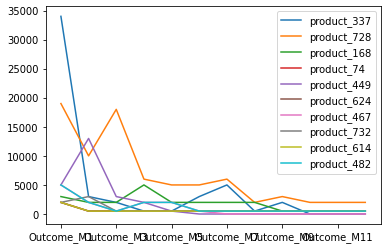

In [76]:
df_plot = pd.DataFrame()

for i in indexes:
  df_plot["product_"+str(i)] = df.iloc[i, 0:12]

df_plot.plot();

#Prepare Data

In [77]:
# firstly, we will separate product features and information about outcome per month

y_train_real = df_train.iloc[:, 0:12].values
print(y_train_real.shape)

y_test_real = df_test.iloc[:, 0:12].values
print(y_test_real.shape)

(600, 12)
(151, 12)


In [78]:
x_train_real = df_train.iloc[:, 12:].values
x_test_real = df_test.iloc[:, 12:].values
print(x_train_real.shape)
print(x_test_real.shape)

(600, 546)
(151, 546)


In [79]:
# scale values in one range for better predictions

from sklearn.preprocessing import MinMaxScaler

#scale datasets
x_scaler = MinMaxScaler()
x_scaler = x_scaler.fit(x_train_real)
x_train = x_scaler.transform(x_train_real)
x_test = x_scaler.transform(x_test_real)

y_scaler = MinMaxScaler()
y_scaler = y_scaler.fit(y_train_real)
y_train = y_scaler.transform(y_train_real)
y_test = y_scaler.transform(y_test_real)

"Now let us move to the most important step of this process: convert price history to multidimensional time series. For each product we will create TimeSeries with 1-12 timesteps with information about product features and previous timestep outcome. We do not know previous outcome for first timestep, so we will just take zero."

In [80]:
# Here we create lists for training and test data, each list will contain 12 3-dimensional numpy arrays. 
# Second dimension for each array will represent timesteps and gradually increases by 1. 

x_train_series = []
x_test_series = []

for k in range(len(y_train[0])):
  x_train_series.append(np.zeros((x_train.shape[0], k+1, x_train.shape[1]+1)))

for k in range(len(y_test[0])):
  x_test_series.append(np.zeros((x_test.shape[0], k+1, x_test.shape[1]+1)))

In [81]:
# Add to each timestep information about product features and previous timestep outcome.
# Now we are using the same product features for each timestep, 
# but the model allows to track features changes on each timestep 
# to make more accurate predictions.

for k in range(len(y_train[0])):
  for i in range(len(x_train)):
    for j in range(k + 1):
      shifted_index = j - 1
      if shifted_index < 0:
        x_train_series[k][i, j] = np.append(x_train[i], 0)
      else:
        x_train_series[k][i, j] = np.append(x_train[i], y_train[i, shifted_index])

In [82]:
# The same timesteps conversion for test data.

for k in range(len(y_test[0])):
  for i in range(len(x_test)):
    for j in range(k + 1):
      shifted_index = j - 1
      if shifted_index < 0:
        x_test_series[k][i, j] = np.append(x_test[i], 0)
      else:
        x_test_series[k][i, j] = np.append(x_test[i], y_test[i, shifted_index])

In [83]:
# Make 12 lists with information about outcome per TimeSerie, per product.

y_train_series = []
y_test_series = []

for k in range(len(y_train[0])):
  y_train_series.append(np.zeros((len(y_train), 1)))
  y_test_series.append(np.zeros((len(y_test), 1)))
 
  
for k in range(len(y_train[0])):
  y_train_series[k] = y_train[:, k].reshape(-1, 1)
  y_test_series[k] = y_test[:, k].reshape(-1, 1)

Review our lists with TimeSeries

In [86]:
print(x_train_series[0].shape)
print(x_test_series[0].shape)
print(x_train_series[11].shape)
print(x_test_series[11].shape)

(600, 1, 547)
(151, 1, 547)
(600, 12, 547)
(151, 12, 547)


In [87]:
print(y_train_series[0].shape)
print(y_test_series[0].shape)
print(y_train_series[11].shape)
print(y_test_series[11].shape)

(600, 1)
(151, 1)
(600, 1)
(151, 1)


#Building LSTM Neural Network

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [89]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, x_train.shape[1]+1)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               823296    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 856,321
Trainable params: 856,321
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(loss='mse', optimizer='rmsprop')

In [91]:
# use %timeit to measure learning time on standard Google Colab instance

%%timeit -r 1 -n 1
for i in range(len(x_train_series)):
  print(i)
  model.fit(x_train_series[i], y_train_series[i], epochs=10, validation_split=0.2)

0
Epoch 1/10
15/15 [==============================] - 3s 63ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 2/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 3/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0129
Epoch 4/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0141
Epoch 5/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 6/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 7/10
15/15 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0137
Epoch 8/10
15/15 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 9/10
15/15 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0124
Epoch 10/10
15/15 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0116
1
Epoch

In [92]:
## Evaluate model for prediction of outcome after several months

for i in range(len(x_test_series)):
  accr = model.evaluate(x_test_series[i], y_test_series[i])
  print("Predicting outcome after {} months. MSE:".format(i), accr)

5/5 [==============================] - 0s 10ms/step - loss: 0.0287
Predicting outcome after 0 months. MSE: 0.02872634120285511
5/5 [==============================] - 0s 15ms/step - loss: 0.0242
Predicting outcome after 1 months. MSE: 0.024169595912098885
5/5 [==============================] - 0s 21ms/step - loss: 0.0119
Predicting outcome after 2 months. MSE: 0.011887386441230774
5/5 [==============================] - 0s 18ms/step - loss: 0.0179
Predicting outcome after 3 months. MSE: 0.017899123951792717
5/5 [==============================] - 0s 22ms/step - loss: 0.0133
Predicting outcome after 4 months. MSE: 0.013292050920426846
5/5 [==============================] - 0s 34ms/step - loss: 0.0196
Predicting outcome after 5 months. MSE: 0.019582780078053474
5/5 [==============================] - 0s 23ms/step - loss: 0.0284
Predicting outcome after 6 months. MSE: 0.02840999886393547
5/5 [==============================] - 0s 26ms/step - loss: 0.0104
Predicting outcome after 7 months. MSE:

In [93]:
prediction = model.predict(x_test_series[11])
prediction.shape

(151, 1)

#Outcome prediction function
We will use our model to create a function that will take information about product features and outcome history during several months. As a result this function will predict future outcome for as many months as you wish.

In [94]:
# our function will take information about outcome during first m months and predict outcome for future months

def predictor(features, history, future):
  '''
  features: list of product features
  history: list with outcome per month
  future: int, number of months to predict outcome
  '''
  if future == 0:
    return history  
  
  p_serie = np.zeros((1, len(history), len(features)+1))  
  
  for j in range(len(history)):
    shifted_index = j - 1
    if shifted_index < 0:
      p_serie[0, j] = np.append(features, 0)
    else:
      p_serie[0, j] = np.append(features, history[shifted_index])
      
  prediction = model.predict(p_serie)    
  
  history.append(prediction[0][0])
  future -= 1  
  
  return predictor(features, history, future)

In [95]:
# we will test our function on a random product n
# we will create two lists. First with outcome history for first m months, second with product features

import random

n = random.choice(range(len(x_test)-1))
m = 6
future = 6

features = x_test[n].tolist()
history = y_test[n, 0:m].tolist()

print("Features: ", features[0:5])
print("Scaled outcome history: ", history)

Features:  [0.0, 0.6984126984126985, 0.5965877289483335, 0.8969072164948454, 0.8296703296703297]
Scaled outcome history:  [0.16541353383458646, 0.030303030303030304, 0.018518518518518517, 0.027027027027027025, 0.024691358024691357, 0.1111111111111111]


In [96]:
prediction = predictor(features, history, future)
print(prediction)
print(y_test[n, :m+future])

[0.16541353383458646, 0.030303030303030304, 0.018518518518518517, 0.027027027027027025, 0.024691358024691357, 0.1111111111111111, 0.1705983, 0.17288882, 0.17496036, 0.17673708, 0.17823851, 0.17950952]
[0.16541353 0.03030303 0.01851852 0.02702703 0.02469136 0.11111111
 0.2        0.0952381  0.08695652 0.08695652 0.6        0.2       ]


In [97]:
y_scaler.inverse_transform([prediction])

array([[90000.        ,  8000.        ,  2000.        ,  2000.        ,
         2000.        ,  3000.        ,  2558.97447467,  3630.66512346,
         4024.08827841,  4064.95295465,  1782.38511086,  1795.09520531]])

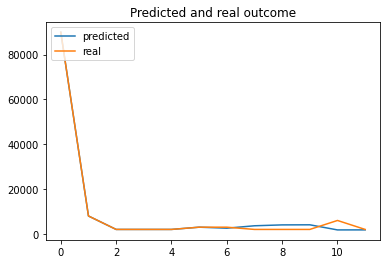

In [98]:
# plot results of prediction comparing real data
plt.plot(y_scaler.inverse_transform([prediction])[0])
plt.plot(y_scaler.inverse_transform([y_test[n, :m+future]])[0])
plt.title('Predicted and real outcome')
plt.legend(['predicted', 'real'], loc='upper left')
axes = plt.gca()

plt.show()

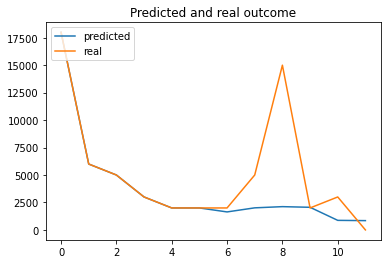

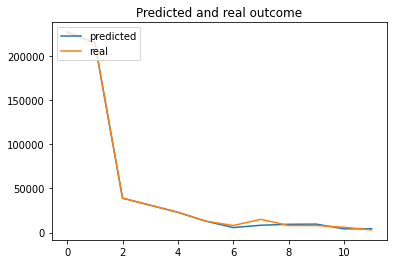

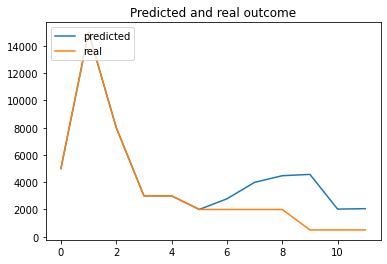

In [99]:
for i in range(3):
  n = random.choice(range(len(x_test)-1))
  m = 6
  future = 6
  features = x_test[n].tolist()
  history = y_test[n, 0:m].tolist()

  prediction = predictor(features, history, future)

  # plot results of prediction comparing real data
  plt.plot(y_scaler.inverse_transform([prediction])[0])
  plt.plot(y_scaler.inverse_transform([y_test[n, :m+future]])[0])
  plt.title('Predicted and real outcome')
  plt.legend(['predicted', 'real'], loc='upper left')
  axes = plt.gca()  
  plt.show()

#Sync prediction to Google Sheet

In [ ]:
!pip install --upgrade oauth2client gspread

In [128]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

sh = gc.create('TrainingDataset2')

# Go to https://sheets.google.com to see your new spreadsheet.
#https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=6d0xJz3VzLOo

"\n# Open our new sheet and add some data.\nworksheet = gc.open('A new spreadsheet').sheet1\n\ncell_list = worksheet.range('A1:C2')\n\nimport random\nfor cell in cell_list:\n  cell.value = random.randint(1, 10)\n\nworksheet.update_cells(cell_list)"

In [135]:
# Open Google Sheet for saving real and predicted data. 
# We have two worksheets in it: "real" for real data, "predicted" for predicted data. (I manually named these two worksheets)

ws = gc.open('TrainingDataset2')

ws_predicted = ws.worksheet('predicted')
ws_real = ws.worksheet('real')

In [143]:
real_data = []
predicted_data = []

for i in range(3):
  n = random.choice(range(len(x_test)-1))
  m = 6
  future = 6
  features = x_test[n].tolist()
  history = y_test[n, 0:m].tolist()

  prediction = predictor(features, history, future)

  predicted_data.append(y_scaler.inverse_transform([prediction])[0])
  real_data.append(y_scaler.inverse_transform([y_test[n, :m+future]])[0])  

In [144]:
# Write our real and predicted data to Google Sheets.
# We will write starting from  the second row, reserving first row for column names(Product1, Product2, Product3)

for j in range(len(real_data)):
  for i in range(len(real_data[0])):
    ws_predicted.update_cell(i+2, j+1, float(predicted_data[j][i]))
    ws_real.update_cell(i+2, j+1, float(real_data[j][i]))
    
    
for i in range(len(real_data[0])):    
    # add index column
    ws_predicted.update_cell(i+2, len(real_data)+1, i)
    ws_real.update_cell(i+2, len(real_data)+1, i)

In [139]:
predicted_data[0]

array([24000.        , 18000.        ,  2000.        ,  2000.        ,
        3000.        ,   500.        ,   871.63187563,  1026.76170319,
         939.57241625,   789.24888372,   295.03569007,   262.2333914 ])

In [146]:
# Review our data at Google Sheets (I manually named product 1~3 ans series for column name)

ws_real.get_all_records()[6:11]

[{'Product 1': 52000, 'Product 2': 2000, 'Product 3': 16000, 'series': 0},
 {'Product 1': 48000, 'Product 2': 3000, 'Product 3': 10000, 'series': 1},
 {'Product 1': 10000, 'Product 2': 2000, 'Product 3': 3000, 'series': 2},
 {'Product 1': 5000, 'Product 2': 2000, 'Product 3': 2000, 'series': 3},
 {'Product 1': 5000, 'Product 2': 2000, 'Product 3': 2000, 'series': 4},
 {'Product 1': 2000, 'Product 2': 500, 'Product 3': 2000, 'series': 5},
 {'Product 1': 2000, 'Product 2': 500, 'Product 3': 2000, 'series': 6},
 {'Product 1': 3000, 'Product 2': 500, 'Product 3': 5000, 'series': 7},
 {'Product 1': 2000, 'Product 2': 500, 'Product 3': 3000, 'series': 8},
 {'Product 1': 2000, 'Product 2': 500, 'Product 3': 3000, 'series': 9},
 {'Product 1': 3000, 'Product 2': 500, 'Product 3': 0, 'series': 10},
 {'Product 1': 500, 'Product 2': 500, 'Product 3': 0, 'series': 11}]

In [147]:
ws_predicted.get_all_records()[6:11]

[{'Product 1': 2565.324381,
  'Product 2': 717.818588,
  'Product 3': 406.1444476,
  'series': 6},
 {'Product 1': 3681.367323,
  'Product 2': 994.8621914,
  'Product 3': 444.6738437,
  'series': 7},
 {'Product 1': 4128.431082,
  'Product 2': 1097.420856,
  'Product 3': 396.1718529,
  'series': 8},
 {'Product 1': 4215.579286,
  'Product 2': 1108.99388,
  'Product 3': 338.6957273,
  'series': 9},
 {'Product 1': 1866.296828,
  'Product 2': 487.2814566,
  'Product 3': 130.5509359,
  'series': 10}]

#Display in Google Data Studio
https://datastudio.google.com/reporting/57558fcf-4060-4f45-bc44-206a619a0a4e
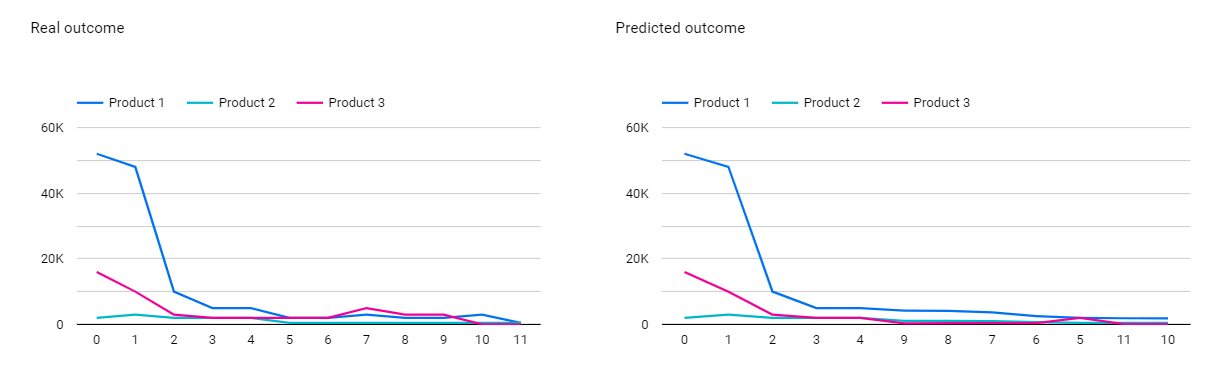